# Hist

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

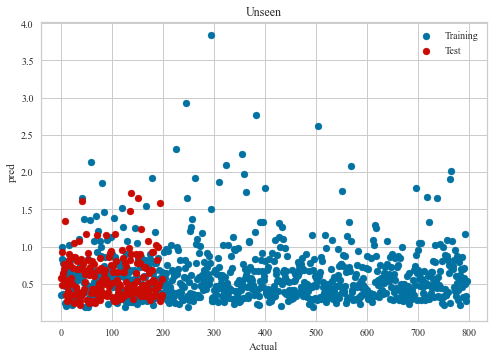

In [111]:

Data=pd.read_csv('1000_y_data.csv')
X = Data[Data.columns[1:23]]
y = Data['rib13']
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=23)

plt.figure()
ind = np.arange(len(y)) 
plt.scatter(ind,y, color="b",label="Training")
ind = np.arange(len(y_Test))
plt.scatter(ind,y_Test, color="r",label="Test")
plt.title("Unseen")
plt.xlabel("Actual")
plt.ylabel("pred")
plt.legend(loc="best")
plt.show()

In [118]:
Data=pd.read_csv('1000_y_data.csv')
X = Data[Data.columns[1:23]]
y = Data['rib13']

In [127]:
y.mean()

0.60905245619598

In [15]:
hist_grid = {"learning_rate"   : [0.15,0.2,0.25],
             "max_iter":[200,250,300],
             "max_leaf_nodes":[13,14,15],
#              "l2_regularization":[0.58],
             "scoring":['neg_root_mean_squared_error'],
             'max_depth'        : [4,5,6],
             "min_samples_leaf" :[7,8,9]
             }

In [16]:
# Use the random grid to search for best hyperparameters
yt=np.log(y)
rf = HistGradientBoostingRegressor()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = hist_grid, n_iter = 200, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,yt)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  6.4min finished


RandomizedSearchCV(cv=10, estimator=HistGradientBoostingRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.2, 0.25],
                                        'max_depth': [4, 5, 6],
                                        'max_iter': [200, 250, 300],
                                        'max_leaf_nodes': [13, 14, 15],
                                        'min_samples_leaf': [7, 8, 9],
                                        'scoring': ['neg_root_mean_squared_error']},
                   random_state=42, verbose=2)

In [17]:
rf_random.best_estimator_

HistGradientBoostingRegressor(learning_rate=0.2, max_depth=5, max_iter=300,
                              max_leaf_nodes=14, min_samples_leaf=9,
                              scoring='neg_root_mean_squared_error')

In [87]:
modo=HistGradientBoostingRegressor(learning_rate=0.05, max_depth=2, max_iter=250,
                              max_leaf_nodes=7, min_samples_leaf=9,
                              scoring='neg_root_mean_squared_error',l2_regularization=15)
mod = TransformedTargetRegressor(regressor=modo,func=np.log,inverse_func=np.exp)

In [88]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [89]:
Data=pd.read_csv('1000_y_data.csv')
X = Data[Data.columns[1:23]]
y = Data['rib13']
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=23)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')


<Figure size 576x396 with 0 Axes>

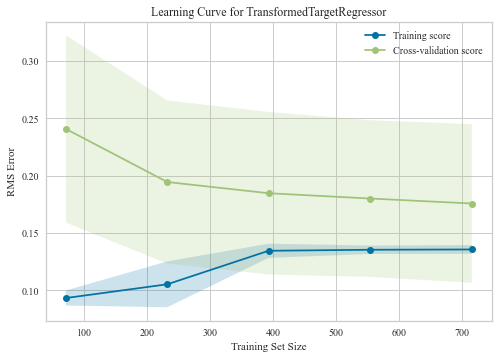

In [90]:

train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
csfont = {'fontname':'Times New Roman'}    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]),**csfont)
plt.xlabel("Training Set Size",**csfont)
plt.ylabel("RMS Error",**csfont)
plt.legend(loc="best")
plt.show()

In [91]:
X = X.to_numpy()
y = y.to_numpy()


In [92]:
y_Test=y_Test.to_numpy()

In [93]:
kf=cv

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 0.146755

Root Mean squared error: 0.155120

Root Mean squared error: 0.129087

Root Mean squared error: 0.341705

Root Mean squared error: 0.253278

Root Mean squared error: 0.130373

Root Mean squared error: 0.203914

Root Mean squared error: 0.136747

Root Mean squared error: 0.096054

Root Mean squared error: 0.161363

error COV--->0    1.188337
dtype: float64  error mean --->0    0.075706
Name: mean, dtype: float64  error std --->0    0.089964
Name: std, dtype: float64


# train score

In [94]:
ytr=HBM_Train.predict(X)
err=np.zeros(len(ytr))
for u in range (0,len(ytr)):
    err[u]=np.sqrt((y[u]-ytr[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    1.620164
dtype: float64  error mean --->0    0.071623
Name: mean, dtype: float64  error std --->0    0.11604
Name: std, dtype: float64


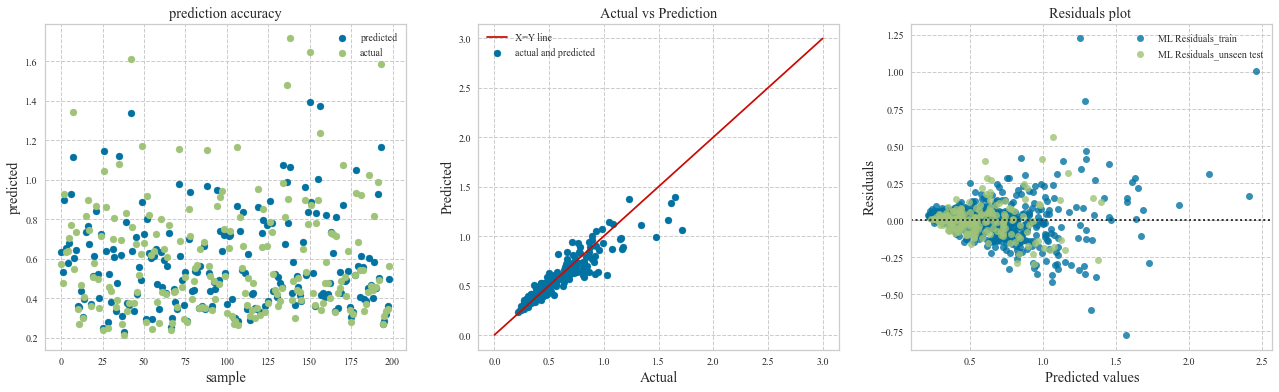

In [95]:
plt.figure(figsize=(22, 6))
csfont = {'fontname':'Times New Roman'}
plt.subplot(1,3,1)
plt.scatter(np.arange(0,len(ytestunk)),ytestunk,label='predicted')
plt.scatter(np.arange(0,len(y_Test)),y_Test,label='actual')
plt.grid( linestyle='--')
plt.title('prediction accuracy', fontsize='large',**csfont)
plt.xlabel('sample', fontsize='large',**csfont)
plt.ylabel('predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,2)
plt.scatter(y_Test,ytestunk,label='actual and predicted')
plt.plot([0,3],[0,3],color='r',label='X=Y line')
plt.grid( linestyle='--')
plt.title('Actual vs Prediction', fontsize='large',**csfont)
plt.xlabel('Actual', fontsize='large',**csfont)
plt.ylabel('Predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,3)
a=sns.residplot(y=abs(y), x=abs(ytr),label='ML Residuals_train')
r=sns.residplot(y=abs(y_Test), x=abs(ytestunk),label='ML Residuals_unseen test')
plt.grid( linestyle='--')
plt.title('Residuals plot ', fontsize='large',**csfont)
plt.xlabel('Predicted values', fontsize='large',**csfont)
plt.ylabel('Residuals', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.show()

# XG

In [97]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve
import xgboost as xg
from sklearn.compose import TransformedTargetRegressor

In [98]:
Data=pd.read_csv('1000_y_data.csv')
X = Data[Data.columns[1:23]]
y = Data['rib13']

In [99]:
param_tuning = {
        'learning_rate': [0.04,0.05],
        'max_depth': [4,5],
        'min_child_weight': [15,16,17],
        'subsample': [0.55],
         'gamma'  : [0.05,0.075],
        'colsample_bytree': [0.75,0.8],
        'n_estimators' : [50,70,90]}

In [100]:
yt=np.log(y)
rf = xg.XGBRegressor()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_tuning, n_iter = 400, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,yt)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 144 is smaller than n_iter=400. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.4min finished


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_meth

In [101]:
rf_random.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=15, missing=nan, monotone_constraints='()',
             n_estimators=90, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.55,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
modo=xg.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=15, monotone_constraints='()',
             n_estimators=90, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.55,
             tree_method='exact', validate_parameters=1, verbosity=None)

mod = TransformedTargetRegressor(regressor=modo,func=np.log,inverse_func=np.exp)

In [103]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [104]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=23)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')


<Figure size 576x396 with 0 Axes>

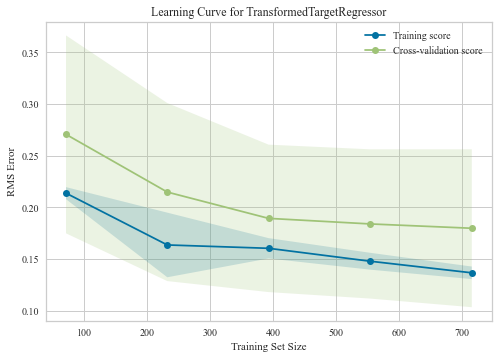

In [105]:

train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

In [106]:
X = X.to_numpy()
y = y.to_numpy()

In [107]:
y_Test=y_Test.to_numpy()

In [108]:
kf=cv
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 0.133925

Root Mean squared error: 0.139624

Root Mean squared error: 0.142784

Root Mean squared error: 0.351517

Root Mean squared error: 0.283991

Root Mean squared error: 0.118280

Root Mean squared error: 0.202873

Root Mean squared error: 0.137729

Root Mean squared error: 0.099101

Root Mean squared error: 0.171784

error COV--->0    1.215451
dtype: float64  error mean --->0    0.068556
Name: mean, dtype: float64  error std --->0    0.083327
Name: std, dtype: float64


# train score

In [109]:
ytr=HBM_Train.predict(X)
err=np.zeros(len(ytr))
for u in range (0,len(ytr)):
    err[u]=np.sqrt((y[u]-ytr[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    1.881892
dtype: float64  error mean --->0    0.065799
Name: mean, dtype: float64  error std --->0    0.123826
Name: std, dtype: float64


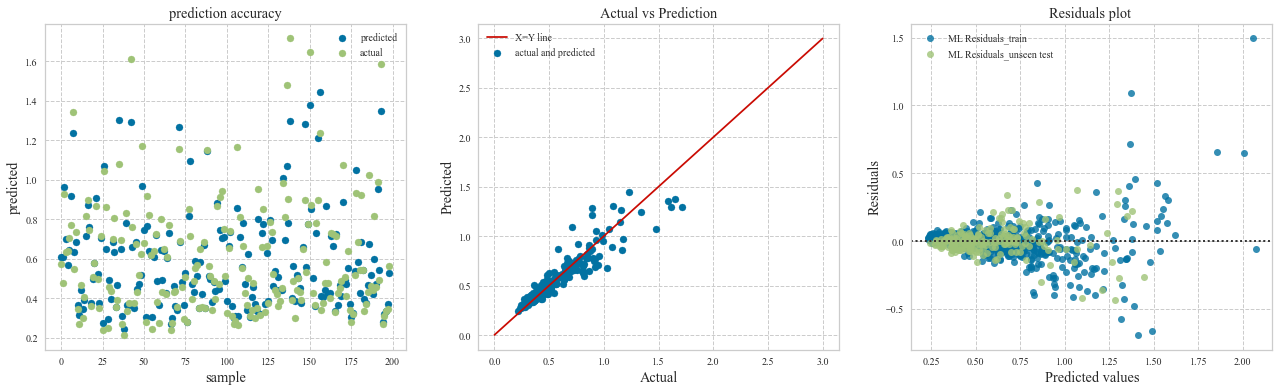

In [110]:
plt.figure(figsize=(22, 6))
csfont = {'fontname':'Times New Roman'}
plt.subplot(1,3,1)
plt.scatter(np.arange(0,len(ytestunk)),ytestunk,label='predicted')
plt.scatter(np.arange(0,len(y_Test)),y_Test,label='actual')
plt.grid( linestyle='--')
plt.title('prediction accuracy', fontsize='large',**csfont)
plt.xlabel('sample', fontsize='large',**csfont)
plt.ylabel('predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,2)
plt.scatter(y_Test,ytestunk,label='actual and predicted')
plt.plot([0,3],[0,3],color='r',label='X=Y line')
plt.grid( linestyle='--')
plt.title('Actual vs Prediction', fontsize='large',**csfont)
plt.xlabel('Actual', fontsize='large',**csfont)
plt.ylabel('Predicted', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.subplot(1,3,3)
a=sns.residplot(y=abs(y), x=abs(ytr),label='ML Residuals_train')
r=sns.residplot(y=abs(y_Test), x=abs(ytestunk),label='ML Residuals_unseen test')
plt.grid( linestyle='--')
plt.title('Residuals plot ', fontsize='large',**csfont)
plt.xlabel('Predicted values', fontsize='large',**csfont)
plt.ylabel('Residuals', fontsize='large',**csfont)
plt.rcParams["font.family"] = "Times New Roman"
plt.legend()

plt.show()